# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

#### Выполнила: Кудаева Вика М8О-310Б-23

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("datasets/X_train.txt")
y_train = np.loadtxt("datasets/y_train.txt").astype(int)

X_test = np.loadtxt("datasets/X_test.txt")
y_test = np.loadtxt("datasets/y_test.txt").astype(int)

In [4]:
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [5]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

Определим число уникальных значений меток целевого класса.

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [8]:
n_classes = np.unique(y).size
print(n_classes)

6


[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [12]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print(f"Исходная размерность: {X_scaled.shape[1]} признак")
print(f"Новая размерность: {X_pca.shape[1]} главных признаков")

Исходная размерность: 561 признак
Новая размерность: 65 главных признаков


**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- 65
- 66
- 193

In [16]:
pca.n_components_

65

**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51
- 56
- 61

In [19]:
first_component_variance = pca.explained_variance_ratio_[0]
print(f'{round(first_component_variance * 100)}%')

51%


Визуализируйте данные в проекции на первые две главные компоненты.

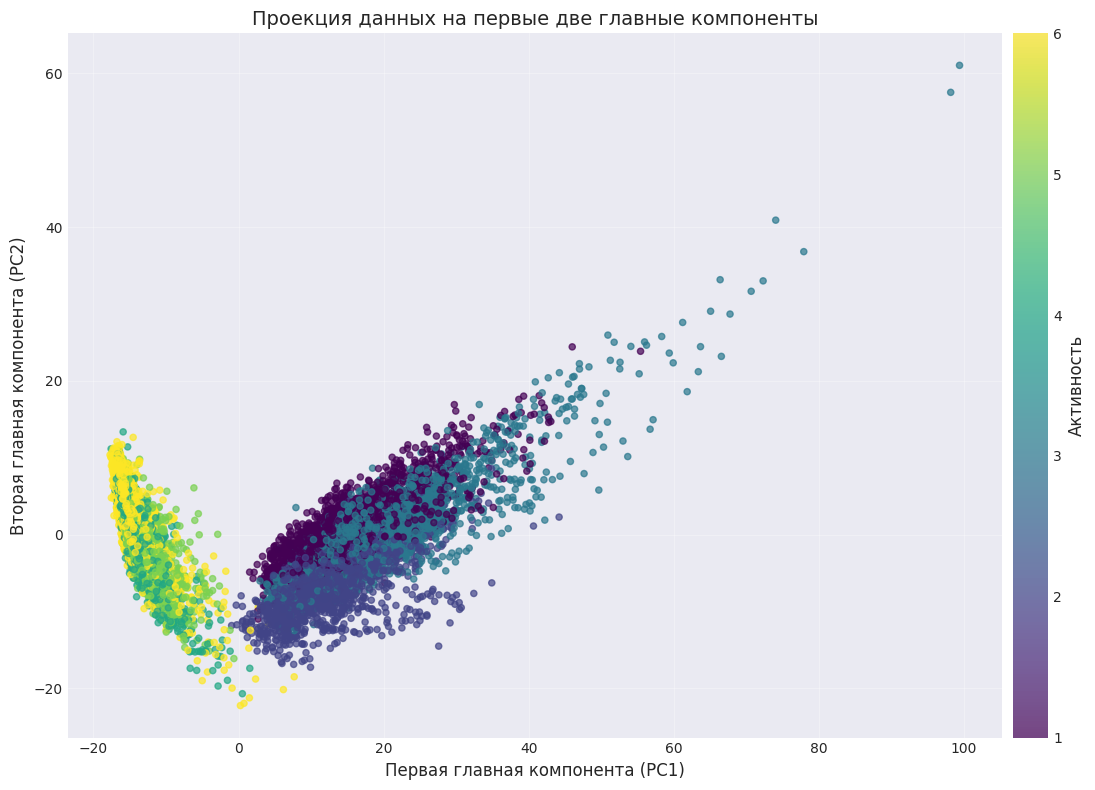

In [24]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=y,          
                     s=20,          
                     cmap='viridis', 
                     alpha=0.7)    

plt.xlabel('Первая главная компонента (PC1)', fontsize=12)
plt.ylabel('Вторая главная компонента (PC2)', fontsize=12)
plt.title('Проекция данных на первые две главные компоненты', fontsize=14)
cbar = plt.colorbar(scatter, pad=0.01)
cbar.set_label('Активность', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ: 2 кластера, первый: ходьба, подъем вверх по лестнице, спуск по лестнице, второй: сидение, стояние, лежание**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [26]:
n_clusters = n_classes 
n_init = 100
random_state = RANDOM_STATE

kmeans_pca = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
cluster_labels_pca = kmeans_pca.fit_predict(X_pca)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

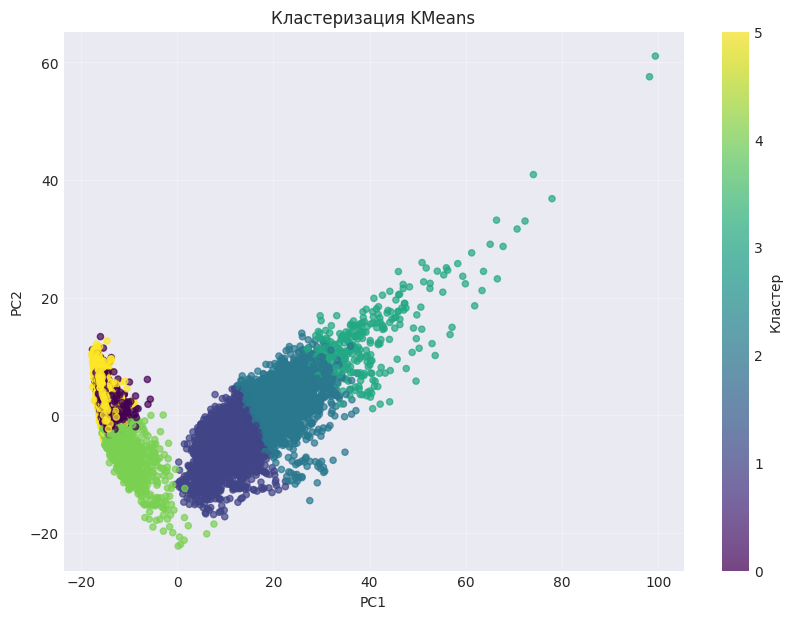

In [29]:
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_pca, s=20, cmap='viridis', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Кластеризация KMeans')
plt.colorbar(label='Кластер')
plt.grid(alpha=0.3)
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [31]:
tab = pd.crosstab(y, cluster_labels_pca, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ: перечисленные варианты не подходят, лучше всего отделился клсс "подъём вверх по лестнице"**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [35]:
inertia = []
for k in tqdm(range(1, 11)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

print("Инерция для разного числа кластеров:")
for k, inert in enumerate(inertia, 1):
    print(f"k = {k:2d}: инерция = {inert:,.0f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Инерция для разного числа кластеров:
k =  1: инерция = 5,202,758
k =  2: инерция = 2,697,927
k =  3: инерция = 2,346,425
k =  4: инерция = 2,207,132
k =  5: инерция = 2,080,985
k =  6: инерция = 2,003,455
k =  7: инерция = 1,946,200
k =  8: инерция = 1,892,345
k =  9: инерция = 1,841,681
k = 10: инерция = 1,799,907


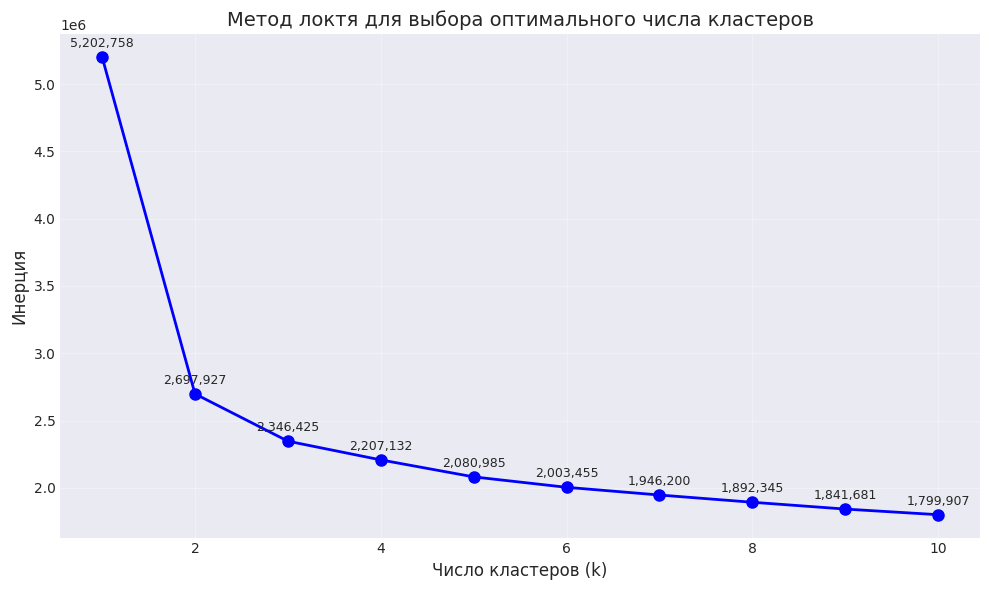

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Число кластеров (k)', fontsize=12)
plt.ylabel('Инерция', fontsize=12)
plt.title('Метод локтя для выбора оптимального числа кластеров', fontsize=14)
plt.grid(True, alpha=0.3)

for k, inert in enumerate(inertia, 1):
    plt.text(k, inert + inertia[0]*0.01, f'{inert:,.0f}', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ: 3, так как на графике инерции виден явный изгиб при k=3, где резкое начальное уменьшение инерции (от k=1 к k=3) сменяется плавным снижением.**
- 1
- 2
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [37]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [42]:
ari_ag = adjusted_rand_score(y, ag_labels)
kmeans_q4 = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans_labels_q4 = kmeans_q4.fit_predict(X_pca)
ari_kmeans = adjusted_rand_score(y, kmeans_labels_q4)

print(f"ARI (Агломеративная кластеризация): {ari_ag:.4f}")
print(f"ARI (KMeans): {ari_kmeans:.4f}")

ARI (Агломеративная кластеризация): 0.4936
ARI (KMeans): 0.4198


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты: все утверждения верные**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=5000)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [46]:
grid_search = GridSearchCV(svc, svc_params, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

,estimator,LinearSVC(max...ndom_state=17)
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [47]:
best_svc = grid_search.best_estimator_

In [48]:
print(f"Лучший параметр C: {grid_search.best_params_['C']}")

Лучший параметр C: 0.1


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ: 0.1**
- 0.001
- 0.01
- 0.1
- 1
- 10

In [49]:
y_predicted = best_svc.predict(X_test_scaled)

In [50]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,427,60,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,443,588,526,2947


In [52]:
precision_scores = {}
recall_scores = {}

for i in range(6):
    activity = tab.index[i]
    tp = tab.iloc[i, i]
    all_predicted = tab.iloc[-1, i]
    all_true = tab.iloc[i, -1]
    precision = tp / all_predicted if all_predicted > 0 else 0
    recall = tp / all_true if all_true > 0 else 0
    precision_scores[activity] = precision
    recall_scores[activity] = recall
    print(f"{activity:25} Precision: {precision:.3f} | Recall: {recall:.3f}")

worst_precision = min(precision_scores, key=precision_scores.get)
worst_recall = min(recall_scores, key=recall_scores.get)

print(f"\nХудшая точность: {worst_precision} ({precision_scores[worst_precision]:.3f})")
print(f"Худшая полнота: {worst_recall} ({recall_scores[worst_recall]:.3f})")

ходьба                    Precision: 0.972 | Recall: 0.996
подъем вверх по лестнице  Precision: 0.979 | Recall: 0.975
спуск по лестнице         Precision: 1.000 | Recall: 0.983
сидение                   Precision: 0.964 | Recall: 0.870
стояние                   Precision: 0.879 | Recall: 0.972
лежание                   Precision: 1.000 | Recall: 0.980

Худшая точность: стояние (0.879)
Худшая полнота: сидение (0.870)


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ: по точности – стояние, по полноте – сидение.**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4%
- 10%
- 20%

**Ответ: 4%**

In [53]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [55]:
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=5000)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [56]:
grid_search_pca = GridSearchCV(svc, svc_params, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_pca.fit(X_train_pca, y_train)

,estimator,LinearSVC(max...ndom_state=17)
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [58]:
score_no_pca = grid_search.best_score_
score_pca = grid_search_pca.best_score_
diff_percent = round((score_no_pca - score_pca) * 100)

print(f"Без PCA: {score_no_pca:.4f} ({score_no_pca*100:.1f}%)")
print(f"С PCA: {score_pca:.4f} ({score_pca*100:.1f}%)")
print(f"Разность: {diff_percent}%")

Без PCA: 0.9381 (93.8%)
С PCA: 0.8984 (89.8%)
Разность: 4%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
1) Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
2) PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
3) PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

**Ответ: 2) и 3)**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

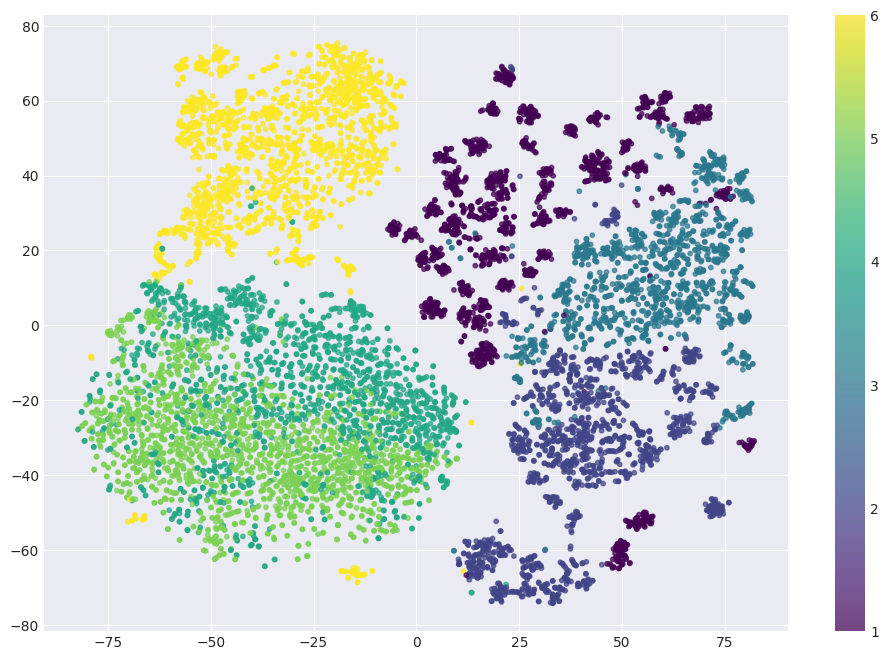

In [63]:
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
X_tsne = tsne.fit_transform(X_pca)
dbs = DBSCAN(eps=4.2, min_samples=5)
X_dbs = dbs.fit_predict(X_pca)

plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=10, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.show()